In [84]:
import os
from datetime import datetime

In [85]:
c = os.getcwd()

In [86]:
print(c)

/home/jupyterlab/virus-data-voila/mongodb


In [87]:
import pandas as pd
import numpy as np

In [88]:
os.environ['MPLCONFIGDIR'] = c

In [89]:
import xlsxwriter
import xlrd
import matplotlib

In [90]:
from datetime import datetime
my_date = datetime.now()
print(my_date.isoformat())
#print(my_date.strftime('%Y-%m-%dT%H:%M:%S.%f%z'))
#2020-06-15T15:18:53.632557
runid = "R" + my_date.strftime('%Y%m%d%H%M%S%f%z')
runid

2021-02-04T17:22:41.886206


'R20210204172241886206'

In [91]:
def validate_date(date_text):
    try:
        format_string = '%Y-%m-%d %H:%M:%S'
        datetime.strptime(date_text, format_string)
        return "OK"
    except ValueError:
        return None

def GetDataType(row_in):
    valueasstring = str(row_in['CellValue'])
    if validate_date(valueasstring) != None:
        return 'Date'
    elif valueasstring.isnumeric():
        return 'Number'
    else:
        return 'Text'

def add1_2row(row_in):
    return row_in['RowID'] + 1


def add1_2column(row_in):
    return row_in['ColumnID'] + 1

In [92]:
import io

In [93]:
filedf = pd.read_excel("/home/jupyterlab/virus-data-voila/mongodb/DataModel.xlsx",sheet_name=None, header=None, engine="openpyxl")

In [94]:
sheetnames = list(filedf.keys())

In [95]:
sheetnames

['Entity & Code List Definitions',
 'Attributes',
 'Codes',
 'UniclassSystemCode',
 'UniclassProductCode',
 'UniclassEntityCode',
 'UniclassElementFunctionCode',
 'UniclassComplexCode',
 'UniclassActivityCode',
 'M3NHFScheduleOfRatesCode',
 'CoordinateReferenceSystemCode']

In [96]:
celldbstagedf = pd.DataFrame()

In [97]:
for currentsheetname in sheetnames:

    sheetdf = filedf[currentsheetname].copy()
    sheetdf["RowID"] = sheetdf.index
    celldb = pd.melt(sheetdf, id_vars=['RowID'])
    celldb = celldb.rename(columns={"variable": "ColumnID", "value": "CellValue"})
    celldb["CellType"] = "Unset"
    celldb["FileName"] = runid
    celldb["SheetName"] = currentsheetname
    
    celldb["ColumnID"] = celldb["ColumnID"]

    try:
        celldb["CellType"] = celldb.apply(GetDataType, axis=1)
        celldb["RowID"] = celldb.apply(add1_2row, axis=1)
        celldb["ColumnID"] = celldb.apply(add1_2column, axis=1)

    except:

        celldb["CellType"] = 'unknown'
        celldb["RowID"] = 0
        celldb["ColumnID"] = 0

    celldbstagedf = celldbstagedf.append(celldb, ignore_index=True)

    celldb = pd.DataFrame()

In [98]:
fullcelldb = celldbstagedf

In [99]:
Cells = pd.DataFrame()
Cells = fullcelldb[(fullcelldb['SheetName'] == 'UniclassComplexCode')].copy()
Cells.head()

,RowID,ColumnID,CellValue,CellType,FileName,SheetName
247566,1,1,Code List,Text,R20210204172241886206,UniclassComplexCode
247567,2,1,UniclassComplexCode,Text,R20210204172241886206,UniclassComplexCode
247568,3,1,UniclassComplexCode,Text,R20210204172241886206,UniclassComplexCode
247569,4,1,UniclassComplexCode,Text,R20210204172241886206,UniclassComplexCode
247570,5,1,UniclassComplexCode,Text,R20210204172241886206,UniclassComplexCode


In [100]:
##Below extracts a Sheet from the cell database and reshapes it to it original tabular form.
Table = pd.DataFrame()
Table = Cells.pivot_table(index = ['RowID'], values = 'CellValue',columns = 'ColumnID', aggfunc = 'max')
Headings = Table.iloc[0]
HeadingsList = list(Headings)
print(HeadingsList)

['Code List', 'Name', 'Documentation', 'Code', 1.1, 1.7]


In [101]:
HeadingsListTuple = enumerate(HeadingsList,start=1)
HeadingsListDict = dict(HeadingsListTuple)
print(HeadingsListDict)
Table = Table.rename(columns=HeadingsListDict)
Table = Table.drop([1])
Table.head()

{1: 'Code List', 2: 'Name', 3: 'Documentation', 4: 'Code', 5: 1.1, 6: 1.7}


ColumnID,Code List,Name,Documentation,Code,1.1,1.7
RowID,,,,,,
2,UniclassComplexCode,"Administrative, commercial and protective serv...",NaN,Co_20,Y,Y
3,UniclassComplexCode,Legislative complexes,NaN,Co_20_10,Y,Y
4,UniclassComplexCode,Governmental complexes,NaN,Co_20_10_60,Y,Y
5,UniclassComplexCode,Administrative complexes,NaN,Co_20_15,Y,Y
6,UniclassComplexCode,Business parks,NaN,Co_20_15_08,Y,Y


In [102]:
Table['Length'] = Table['Code'].str.len().astype(int)

In [103]:
def applyFunc(s):
    if s == 5:
        return 1
    elif s == 8:
        return 2
    elif s == 11:
        return 3
    return 0

Table['Level'] = Table['Length'].apply(applyFunc)

In [104]:
##Table['Parent'] = Table['Code'].str.slice(start=0, stop=Table['Length']-3)
#Table['Parent'] = Table['Code'].str.slice(start=1)
Table['Parent'] = Table['Code'].str[0:-3]

In [105]:
Table

ColumnID,Code List,Name,Documentation,Code,1.1,1.7,Length,Level,Parent
RowID,,,,,,,,,
2,UniclassComplexCode,"Administrative, commercial and protective serv...",NaN,Co_20,Y,Y,5,1,Co
3,UniclassComplexCode,Legislative complexes,NaN,Co_20_10,Y,Y,8,2,Co_20
4,UniclassComplexCode,Governmental complexes,NaN,Co_20_10_60,Y,Y,11,3,Co_20_10
5,UniclassComplexCode,Administrative complexes,NaN,Co_20_15,Y,Y,8,2,Co_20
6,UniclassComplexCode,Business parks,NaN,Co_20_15_08,Y,Y,11,3,Co_20_15
...,...,...,...,...,...,...,...,...,...
377,UniclassComplexCode,Warehouses,NaN,Co_90_50_94,Y,Y,11,3,Co_90_50
378,UniclassComplexCode,Wastewater storage complexes,NaN,Co_90_50_95,Y,Y,11,3,Co_90_50
379,UniclassComplexCode,Water storage complexes,NaN,Co_90_50_96,Y,Y,11,3,Co_90_50


In [106]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

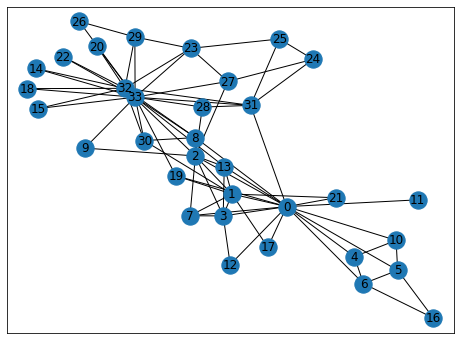

In [107]:
g = nx.karate_club_graph()
fig, ax = plt.subplots(1, 1, figsize=(8, 6));
nx.draw_networkx(g, ax=ax)

In [114]:
from treelib import Node, Tree
tree = Tree()
tree.create_node('Company', 'Co')

Node(tag=Company, identifier=Co, data=None)

In [115]:
for index, row in Table.iterrows():
    #print row['c1'], row['c2']
    tree.create_node(row['Name'], row['Code'],parent=row['Parent'])  # root node

In [116]:
tree.show()

Company
├── Administrative, commercial and protective service complexes
│   ├── Administrative complexes
│   │   ├── Business parks
│   │   └── Office complexes
│   ├── Commercial complexes
│   │   ├── Auction complexes
│   │   ├── Market complexes
│   │   ├── Mixed use complexes
│   │   ├── Parade of shops
│   │   ├── Retail parks
│   │   ├── Shopping complexes
│   │   └── Vehicle sales complexes
│   ├── Detention complexes
│   │   ├── Immigrant detention complexes
│   │   ├── Prison complexes
│   │   └── Refugee detention complexes
│   ├── Incident support complexes
│   │   ├── Air and sea rescue complexes
│   │   ├── Coastguard stations
│   │   ├── Fire brigade complexes
│   │   ├── Lifeboat stations
│   │   └── Mountain rescue complexes
│   ├── Judicial complexes
│   │   ├── Court complexes
│   │   └── Probation complexes
│   ├── Law enforcement complexes
│   │   └── Law enforcement agency complexes
│   ├── Legislative complexes
│   │   └── Governmental complexes
│   ├── Military c

In [123]:
codes_list = []
parents_list = []
for index, row in Table.iterrows():
    codes_list.append(row['Code'])
    parents_list.append(row['Parent'])
codes_list

['Co_20',
 'Co_20_10',
 'Co_20_10_60',
 'Co_20_15',
 'Co_20_15_08',
 'Co_20_15_58',
 'Co_20_20',
 'Co_20_20_15',
 'Co_20_20_40',
 'Co_20_20_50',
 'Co_20_20_70',
 'Co_20_45',
 'Co_20_45_50',
 'Co_20_45_54',
 'Co_20_50',
 'Co_20_50_05',
 'Co_20_50_50',
 'Co_20_50_53',
 'Co_20_50_60',
 'Co_20_50_71',
 'Co_20_50_78',
 'Co_20_50_94',
 'Co_20_55',
 'Co_20_55_10',
 'Co_20_60',
 'Co_20_60_02',
 'Co_20_60_10',
 'Co_20_60_56',
 'Co_20_65',
 'Co_20_65_56',
 'Co_20_70',
 'Co_20_70_18',
 'Co_20_70_65',
 'Co_20_75',
 'Co_20_75_42',
 'Co_20_75_64',
 'Co_20_75_71',
 'Co_20_80',
 'Co_20_80_04',
 'Co_20_80_80',
 'Co_20_90',
 'Co_20_90_02',
 'Co_20_90_16',
 'Co_20_90_27',
 'Co_20_90_47',
 'Co_20_90_53',
 'Co_25',
 'Co_25_05',
 'Co_25_10',
 'Co_25_10_32',
 'Co_25_10_41',
 'Co_25_10_45',
 'Co_25_10_66',
 'Co_25_10_77',
 'Co_25_10_88',
 'Co_25_10_92',
 'Co_25_30',
 'Co_25_30_04',
 'Co_25_30_08',
 'Co_25_30_45',
 'Co_25_30_70',
 'Co_25_50',
 'Co_25_50_03',
 'Co_25_50_33',
 'Co_25_50_34',
 'Co_25_50_50',
 'Co

In [124]:
import plotly.express as px
fig = px.treemap(
    names = codes_list,
    parents = parents_list
)
fig.show()